In [35]:
#imports and setup
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from itertools import cycle

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

#os_vitals = pd.read_csv('os_vitals.csv')
pa_demo = pd.read_csv('ali_screen.csv')
base_labs = pd.read_csv('base_lab.csv')
base_ven = pd.read_csv('base_ven.csv')
os_labs = pd.read_csv('os_labs.csv')
os_vent = pd.read_csv('os_vent.csv')
term = pd.read_csv('term.csv')

**Cleaning + Merging**

In [2]:
#show columns of demographics csv
pa_demo.columns.tolist()

#rename data frame and select columns to keep
demographics = pa_demo[['ptid','Visit', 'gender','ethnic','age']].copy()

#show head of demographics df
demographics.head()

,ptid,Visit,gender,ethnic,age
0,05-000,0,2,2,46
1,05-001,0,2,2,37
2,05-002,0,2,1,34
3,05-003,0,2,6,40
4,05-004,0,2,1,45


**Gender**
* 1 = male
* 2 = female

**Ethnicity**
* 1 = "White"
* 2 = "Black"
* 3 = "Hispanic"
* 4 = "Asian/Pacific Islander"
* 5 = "American Indian/Alaskan Native"
* 6 = "other"

In [3]:
#check columns in base_labs csv file
base_labs.columns.tolist()

#create copy only keeping columns needed for calculations
baseline_labs = base_labs[['ptid', 'Visit','hgb','pmvo2b', 'pmvco2b', 'mvphb', 'bmvo2sat', 'pcvo2b', 'pcvco2b', 'cvphb', 'cvo2sat']].copy()

#select column to convert to numeric BASE LABS
base_labs_cols_to_convert = ['hgb','pmvo2b', 'pmvco2b', 'mvphb', 'bmvo2sat', 'pcvo2b', 'pcvco2b', 'cvphb', 'cvo2sat']

#convert base_labs to numeric
baseline_labs[base_labs_cols_to_convert] = baseline_labs[base_labs_cols_to_convert].apply(pd.to_numeric, errors='coerce')

#show head as checkpoint
#baseline_labs.head()

#check columns in base_ven csv file
base_ven.columns.tolist()

#create copy only keeping columns needed for calculations
baseline_vent = base_ven[['ptid', 'Visit', 'mapres', 'fio2', 'pao2', 'paco2', 'spo2']].copy()

#select column to convert to numeric BASE VENT
baseline_vent_cols_to_convert = ['mapres', 'fio2', 'pao2', 'paco2', 'spo2']

#convert base_vent to numeric
baseline_vent[baseline_vent_cols_to_convert] = baseline_vent[baseline_vent_cols_to_convert].apply(pd.to_numeric, errors = 'coerce')

#show head as checkpoint
baseline_vent.head()

#determine columns in term csv file
term.columns.tolist()

#create copy only keeping columns needed for calculations
death = term[['ptid', 'Visit','st1dt','st2dt','st3dt','status']].copy()

#select column to convert to numeric DEATH
death_cols_to_convert = ['st1dt','st2dt','st3dt','status']

#convert st2dt (outcome) to numeric
death[death_cols_to_convert] = death[death_cols_to_convert].apply(pd.to_numeric, errors = 'coerce')
#create new column in death dataframe for outcome metric

#Create a new column for outcome metric
death['death90'] = 3  # Default to 3 (Unknown)

# Assign values based on status
death.loc[death['status'] == 1, 'death90'] = 1  # Alive
death.loc[death['status'] == 2, 'death90'] = 2  # Dead
        
#show head as checkpoint
death.head(20)

,ptid,Visit,st1dt,st2dt,st3dt,status,death90
0,05-000,7,7.0,NaN,NaN,1,1
1,05-001,17,NaN,17.0,NaN,2,2
2,05-002,3,3.0,NaN,NaN,1,1
3,05-003,16,16.0,NaN,NaN,1,1
4,05-004,28,67.0,NaN,NaN,1,1
5,05-005,28,72.0,NaN,NaN,1,1
6,05-006,12,NaN,12.0,NaN,2,2
7,05-007,1,NaN,1.0,NaN,2,2
8,05-008,11,11.0,NaN,NaN,1,1
9,05-009,25,40.0,NaN,NaN,1,1


In [4]:
#perform inner merge on all above dataframes (demographics, baseline_labs, baseline_vent, death)
base_combo = (demographics
             .merge(baseline_labs, on=['ptid', 'Visit'], how='inner')
             .merge(baseline_vent, on=['ptid', 'Visit'], how='inner')
             .merge(death, on=['ptid'], how='inner'))

base_combo.head()

,ptid,Visit_x,gender,ethnic,age,hgb,pmvo2b,pmvco2b,mvphb,bmvo2sat,...,fio2,pao2,paco2,spo2,Visit_y,st1dt,st2dt,st3dt,status,death90
0,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,0.60,73.0,34.0,96.0,7,7.0,NaN,NaN,1,1
1,05-001,0,2,2,37,8.5,NaN,NaN,NaN,NaN,...,1.00,52.0,47.0,82.0,17,NaN,17.0,NaN,2,2
2,05-002,0,2,1,34,9.7,46.0,55.0,7.33,78.0,...,0.50,72.0,48.0,98.0,3,3.0,NaN,NaN,1,1
3,05-003,0,2,6,40,13.1,NaN,NaN,NaN,NaN,...,0.50,87.0,21.0,100.0,16,16.0,NaN,NaN,1,1
4,05-004,0,2,1,45,10.3,32.0,40.0,7.46,67.0,...,0.35,74.0,34.0,93.0,28,67.0,NaN,NaN,1,1


In [5]:
#after merge calculate PF, SF, OI, OSI, and shunt 

#calculate PF ratio - requires pao2 therefore uses arterial line
base_combo['PFratio'] = base_combo['pao2'] / base_combo['fio2']

#calculate SF ratio for all rows with spo2 <= 97% (by definition SF ratio cannot be calculated if > 97 %) - uses sao2 therefore no arterial line
base_combo['SFratio'] = np.nan  #default to NaN will correct/add if spo2 is <=97
base_combo.loc[base_combo['spo2'] <= 97, 'SFratio'] = base_combo['spo2'] / base_combo['fio2']

#calculate oxygenation index (OI) - requires pao2 and therefore arterial line
base_combo['OI'] = (base_combo['mapres'] * (base_combo['fio2'] * 100)) / base_combo['pao2']

#calculate oxygen saturation index (OSI) - uses sao2 therefore is non-invasive
base_combo['OSI'] = (base_combo['mapres'] * (base_combo['fio2'] * 100)) / base_combo['spo2']

#Shunt

#alveolar gas equation = PAO2 = [(Patm − PH2O) FiO2] − (PaCO2/RQ)
# base_combo['PalvO2'] = ('fio2'*(760 - 47))-('paco2'/0.8) - simplified version

#alveolar gas equation corrected due to large fio2 where simpe equation does not hold 
base_combo['PalvO2'] = (base_combo['fio2'] * (760 - 47)) - ((base_combo['paco2'] * (1 - base_combo['fio2'] * 0.2)) / 0.8)

#alveolar O2 content
base_combo['CalvO2'] = (base_combo['hgb'] * 1.34) + (base_combo['PalvO2'] * 0.003)

#arterial O2 content - spo2 divided by 100 for appropriate units
base_combo['CartO2'] = (1.34 * base_combo['hgb'] * (base_combo['spo2'] / 100)) + (0.003 * base_combo['pao2'])

#venous O2 content - mvo2sat divided by 100 for appropriate units
base_combo['CvenO2'] = (1.34 * base_combo['hgb'] * (base_combo['bmvo2sat'] / 100)) + (0.003 * base_combo['pmvo2b'])

#shunt calculation
base_combo['Shunt'] = (base_combo['CalvO2'] - base_combo['CartO2']) / (base_combo['CalvO2'] - base_combo['CvenO2'])

base_combo.head()


,ptid,Visit_x,gender,ethnic,age,hgb,pmvo2b,pmvco2b,mvphb,bmvo2sat,...,death90,PFratio,SFratio,OI,OSI,PalvO2,CalvO2,CartO2,CvenO2,Shunt
0,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,1,121.666667,160.000000,12.328767,9.375000,390.400,20.869200,19.12908,NaN,NaN
1,05-001,0,2,2,37,8.5,NaN,NaN,NaN,NaN,...,2,52.000000,82.000000,NaN,NaN,666.000,13.388000,9.49580,NaN,NaN
2,05-002,0,2,1,34,9.7,46.0,55.0,7.33,78.0,...,1,144.000000,NaN,8.333333,6.122449,302.500,13.905500,12.95404,10.27644,0.262178
3,05-003,0,2,6,40,13.1,NaN,NaN,NaN,NaN,...,1,174.000000,NaN,8.620690,7.500000,332.875,18.552625,17.81500,NaN,NaN
4,05-004,0,2,1,45,10.3,32.0,40.0,7.46,67.0,...,1,211.428571,265.714286,4.729730,3.763441,210.025,14.432075,13.05786,9.34334,0.270050


In [6]:
#Now have to add new columns with the worst scenario for each calculation

#group by ptid and calculate min or max depending on what is more severe and therefore more likely predictive of death
agg_values = base_combo.groupby('ptid').agg(
    BPFmin=('PFratio', 'min'),
    BSFmin=('SFratio', 'min'),
    BOImax=('OI', 'max'),
    BOSImax=('OSI', 'max'),
    BShuntmax=('Shunt', 'max')
).reset_index()

#merge with base_combo original dataframe
base_combo = base_combo.merge(agg_values, on='ptid', how='left')

#view head of dataset to check results
base_combo.head()

,ptid,Visit_x,gender,ethnic,age,hgb,pmvo2b,pmvco2b,mvphb,bmvo2sat,...,PalvO2,CalvO2,CartO2,CvenO2,Shunt,BPFmin,BSFmin,BOImax,BOSImax,BShuntmax
0,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,390.400,20.869200,19.12908,NaN,NaN,121.666667,160.000000,12.328767,9.375000,NaN
1,05-001,0,2,2,37,8.5,NaN,NaN,NaN,NaN,...,666.000,13.388000,9.49580,NaN,NaN,52.000000,82.000000,NaN,NaN,NaN
2,05-002,0,2,1,34,9.7,46.0,55.0,7.33,78.0,...,302.500,13.905500,12.95404,10.27644,0.262178,144.000000,NaN,8.333333,6.122449,0.262178
3,05-003,0,2,6,40,13.1,NaN,NaN,NaN,NaN,...,332.875,18.552625,17.81500,NaN,NaN,174.000000,NaN,8.620690,7.500000,NaN
4,05-004,0,2,1,45,10.3,32.0,40.0,7.46,67.0,...,210.025,14.432075,13.05786,9.34334,0.270050,211.428571,265.714286,4.729730,3.763441,0.270050


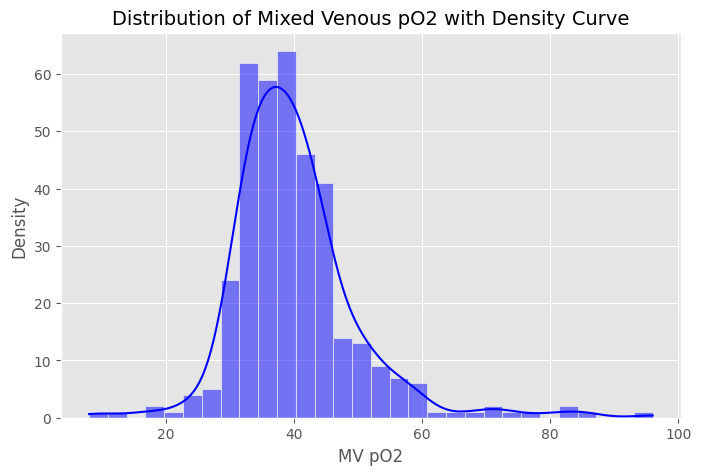

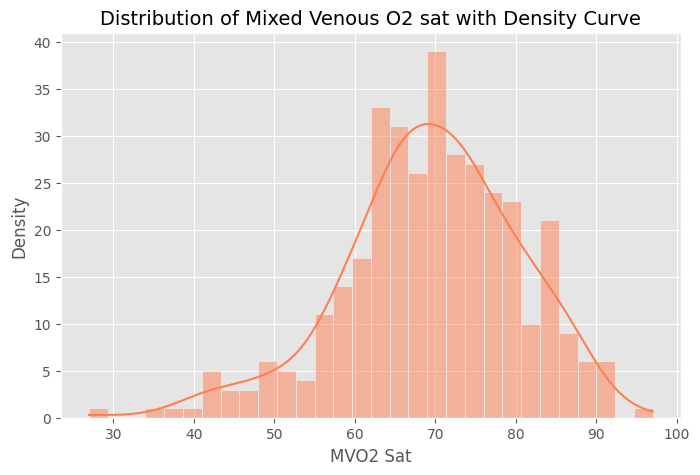

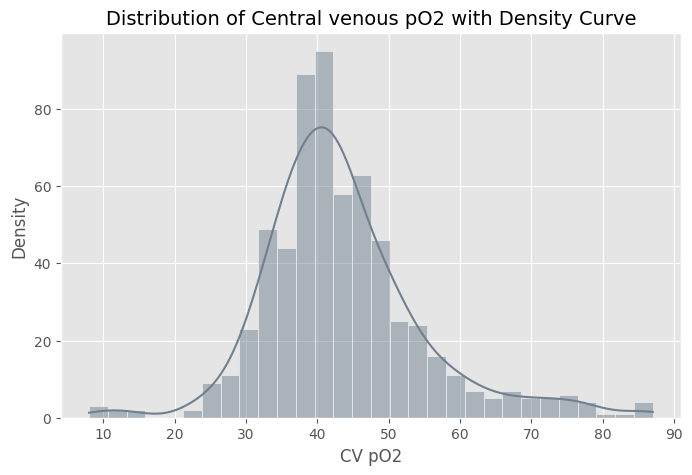

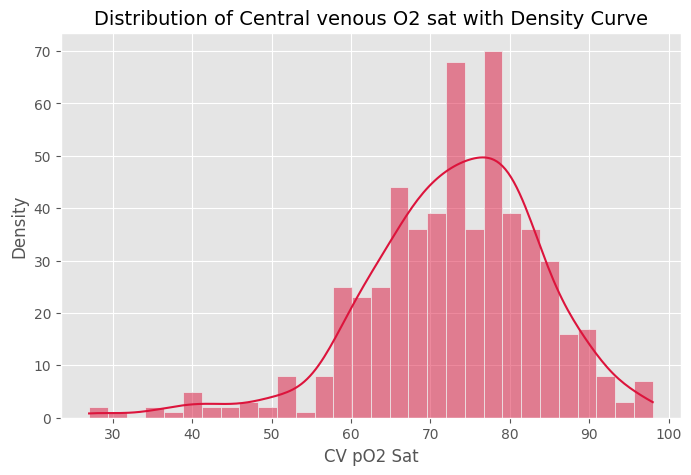

In [7]:
#Plot distribution with density line
plt.figure(figsize=(8, 5))
sns.histplot(base_combo['pmvo2b'], kde=True, bins=30, color='blue')

#Labels and title
plt.xlabel('MV pO2', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Mixed Venous pO2 with Density Curve', fontsize=14)

# Show the plot
plt.show()

#Plot distribution with density line
plt.figure(figsize=(8, 5))
sns.histplot(base_combo['bmvo2sat'], kde=True, bins=30, color='coral')

#Labels and title
plt.xlabel('MVO2 Sat', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Mixed Venous O2 sat with Density Curve', fontsize=14)

# Show the plot
plt.show()

#Plot distribution with density line
plt.figure(figsize=(8, 5))
sns.histplot(base_combo['pcvo2b'], kde=True, bins=30, color='slategray')

# Labels and title
plt.xlabel('CV pO2', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Central venous pO2 with Density Curve', fontsize=14)

#Show the plot
plt.show()

#Plot distribution with density line
plt.figure(figsize=(8, 5))
sns.histplot(base_combo['cvo2sat'], kde=True, bins=30, color='crimson')

# Labels and title
plt.xlabel('CV pO2 Sat', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Central venous O2 sat with Density Curve', fontsize=14)

# Show the plot
plt.show()

**ON STUDY Cleaning + Merging**

In [8]:
#check columns in os_labs csv file
#os_labs.columns.tolist()

#create copy only keeping patient ID, Visit, and hemoglobin columns
on_labs = os_labs[['ptid', 'Visit','hgb']].copy()

#select column to convert to numeric ON STUDY LABS
cols_to_convert_os_labs = ['hgb']

#convert hemoglobin column to numeric
on_labs[cols_to_convert_os_labs] = on_labs[cols_to_convert_os_labs].apply(pd.to_numeric, errors = 'coerce')

#check columns in os_vent csv file
#os_vent.columns.tolist()

#create copy only keeping columns needed for calculations
on_vent = os_vent[['ptid','Visit','mapres','fio2','pao2','paco2','artph','spo2','pmvo2','pmvco2','mvph','mvo2sat','pcvo2','pcvco2','cvph','cvo2sat']].copy() 

#select column to convert to numberic ON STUDY VENT
cols_to_convert_os_vent = ['mapres','fio2','pao2','paco2','artph','spo2','pmvo2','pmvco2','mvph','mvo2sat','pcvo2','pcvco2','cvph','cvo2sat']

#convert on_vent to numeric
on_vent[cols_to_convert_os_vent] = on_vent[cols_to_convert_os_vent].apply(pd.to_numeric, errors = 'coerce')

#check data frame to assess above
#on_vent.head()


In [9]:
#merge the on_study data on both PTID and on VISIT with inner to make sure merge includes all rows with data for on_vent and on_labs
on_combo = pd.merge(on_vent, on_labs, on=['ptid', 'Visit'], how='inner')

# Display first few rows to check the merged DataFrame
on_combo.head()

,ptid,Visit,mapres,fio2,pao2,paco2,artph,spo2,pmvo2,pmvco2,mvph,mvo2sat,pcvo2,pcvco2,cvph,cvo2sat,hgb
0,05-000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
1,05-000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5
2,05-000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.3
3,05-001,1,22.0,0.8,92.0,52.0,7.31,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4
4,05-001,2,23.0,0.7,67.0,68.0,7.23,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.8


In [10]:
#calculate PF ratio - requires pao2 therefore uses arterial line
on_combo['PFratio'] = on_combo['pao2'] / on_combo['fio2']

#calculate SF ratio for all rows with spo2 <= 97% (by definition SF ratio cannot be calculated if > 97 %) - uses sao2 therefore no arterial line
on_combo['SFratio'] = np.nan  #default to NaN will correct/add if spo2 is <=97
on_combo.loc[on_combo['spo2'] <= 97, 'SFratio'] = on_combo['spo2'] / on_combo['fio2']

#calculate oxygenation index (OI) - requires pao2 and therefore arterial line
on_combo['OI'] = (on_combo['mapres'] * (on_combo['fio2'] * 100)) / on_combo['pao2']

#calculate oxygen saturation index (OSI) - uses sao2 therefore is non-invasive
on_combo['OSI'] = (on_combo['mapres'] * (on_combo['fio2'] * 100)) / on_combo['spo2']

#Shunt

#alveolar gas equation = PAO2 = [(Patm − PH2O) FiO2] − (PaCO2/RQ)
# on_combo['PalvO2'] = ('fio2'*(760 - 47))-('paco2'/0.8) - simplified version

#alveolar gas equation corrected due to large fio2 where simpe equation does not hold 
on_combo['PalvO2'] = (on_combo['fio2'] * (760 - 47)) - ((on_combo['paco2'] * (1 - on_combo['fio2'] * 0.2)) / 0.8)

#alveolar O2 content
on_combo['CalvO2'] = (on_combo['hgb'] * 1.34) + (on_combo['PalvO2'] * 0.003)

#arterial O2 content - spo2 divided by 100 for appropriate units
on_combo['CartO2'] = (1.34 * on_combo['hgb'] * (on_combo['spo2'] / 100)) + (0.003 * on_combo['pao2'])

#venous O2 content - mvo2sat divided by 100 for appropriate units
on_combo['CvenO2'] = (1.34 * on_combo['hgb'] * (on_combo['mvo2sat'] / 100)) + (0.003 * on_combo['pmvo2'])

#shunt calculation
on_combo['Shunt'] = (on_combo['CalvO2'] - on_combo['CartO2']) / (on_combo['CalvO2'] - on_combo['CvenO2'])

on_combo.head()

,ptid,Visit,mapres,fio2,pao2,paco2,artph,spo2,pmvo2,pmvco2,...,hgb,PFratio,SFratio,OI,OSI,PalvO2,CalvO2,CartO2,CvenO2,Shunt
0,05-000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,05-000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,05-000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05-001,1,22.0,0.8,92.0,52.0,7.31,96.0,NaN,NaN,...,7.4,115.000000,120.000000,19.130435,18.333333,515.8,11.4634,9.79536,NaN,NaN
4,05-001,2,23.0,0.7,67.0,68.0,7.23,92.0,NaN,NaN,...,9.8,95.714286,131.428571,24.029851,17.500000,426.0,14.4100,12.28244,NaN,NaN


In [11]:
#Now have to add new columns with the worst scenario for each calculation

#group by ptid and calculate min or max depending on what is more severe and therefore more likely predictive of death
agg_values = on_combo.groupby('ptid').agg(
    ONPFmin=('PFratio', 'min'),
    ONSFmin=('SFratio', 'min'),
    ONOImax=('OI', 'max'),
    ONOSImax=('OSI', 'max'),
    ONShuntmax=('Shunt', 'max')
).reset_index()

#merge with on_combo original dataframe
on_combo = on_combo.merge(agg_values, on='ptid', how='left')

on_combo.head()

,ptid,Visit,mapres,fio2,pao2,paco2,artph,spo2,pmvo2,pmvco2,...,PalvO2,CalvO2,CartO2,CvenO2,Shunt,ONPFmin,ONSFmin,ONOImax,ONOSImax,ONShuntmax
0,05-000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,05-000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,05-000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,05-001,1,22.0,0.8,92.0,52.0,7.31,96.0,NaN,NaN,...,515.8,11.4634,9.79536,NaN,NaN,95.714286,120.0,24.029851,18.333333,NaN
4,05-001,2,23.0,0.7,67.0,68.0,7.23,92.0,NaN,NaN,...,426.0,14.4100,12.28244,NaN,NaN,95.714286,120.0,24.029851,18.333333,NaN


In [12]:
#merge new dataframe on 'ptid' only, since visits don't overlap (base_combo only has Visit = 0), keep suffixes of _base and _on when there are duplicates
merged_df = base_combo.merge(on_combo, on='ptid', how='inner', suffixes=('_base', '_on'))

#create new columns for overall min/max calculations to create most severe patient situation
merged_df['PFmin_overall'] = merged_df[['BPFmin', 'ONPFmin']].min(axis=1)
merged_df['SFmin_overall'] = merged_df[['BSFmin', 'ONSFmin']].min(axis=1)
merged_df['OImax_overall'] = merged_df[['BOImax', 'ONOImax']].max(axis=1)
merged_df['OSImax_overall'] = merged_df[['BOSImax', 'ONOSImax']].max(axis=1)
merged_df['Shuntmax_overall'] = merged_df[['BShuntmax', 'ONShuntmax']].max(axis=1)

merged_df.head()

,ptid,Visit_x,gender,ethnic,age,hgb_base,pmvo2b,pmvco2b,mvphb,bmvo2sat,...,ONPFmin,ONSFmin,ONOImax,ONOSImax,ONShuntmax,PFmin_overall,SFmin_overall,OImax_overall,OSImax_overall,Shuntmax_overall
0,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,121.666667,160.0,12.328767,9.375000,NaN
1,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,121.666667,160.0,12.328767,9.375000,NaN
2,05-000,0,2,2,46,14.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,121.666667,160.0,12.328767,9.375000,NaN
3,05-001,0,2,2,37,8.5,NaN,NaN,NaN,NaN,...,95.714286,120.0,24.029851,18.333333,NaN,52.000000,82.0,24.029851,18.333333,NaN
4,05-001,0,2,2,37,8.5,NaN,NaN,NaN,NaN,...,95.714286,120.0,24.029851,18.333333,NaN,52.000000,82.0,24.029851,18.333333,NaN


**Analysis**
* Now that we have a merged dataframe with all variables accounted for that we want to use in analysis we can start analyzing the data
* The first step is to determine the amount of missing data and decide how to approach classifier
* Want to try to predict death at 90 days as well as shunt

death90
1    2615
2    1187
Name: count, dtype: int64
                  Missing Values  Percentage
PFmin_overall                 33    0.867964
SFmin_overall                 83    2.183062
OImax_overall                143    3.761178
OSImax_overall               107    2.814308
Shuntmax_overall            2364   62.177801


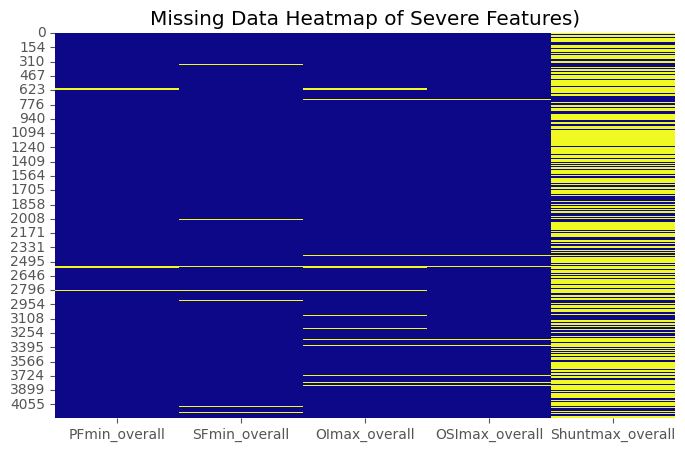

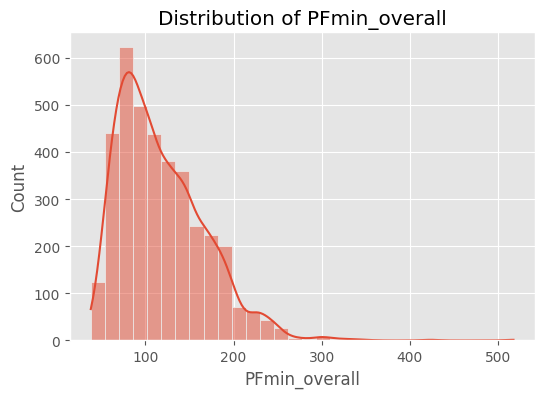

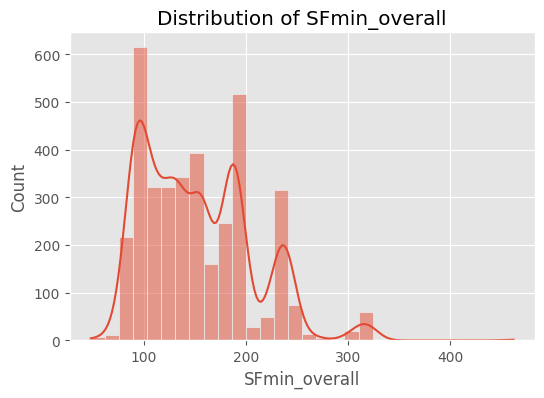

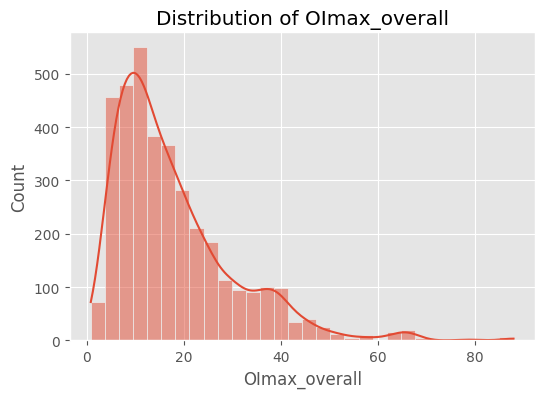

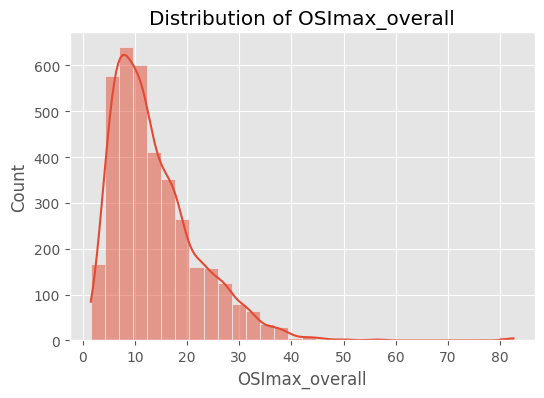

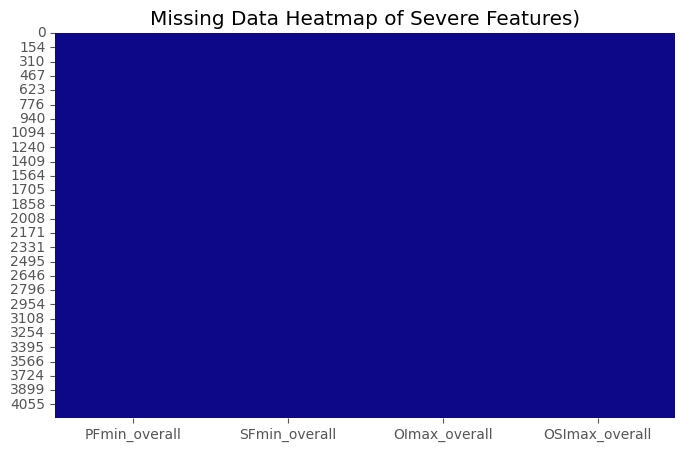

In [13]:
#create copy of above dataframe for use in analysis portion
nb_df_filtered = merged_df.copy()

#Filter out "Unknown" cases (death90 == 3) as the model will try to predict patients in unknown category which is nonsensical
nb_df = nb_df_filtered[nb_df_filtered['death90'] != 3]

#verify that Unknown (3) cases are removed
print(nb_df['death90'].value_counts())

#select severe features and target variable for prediction
features = ['PFmin_overall', 'SFmin_overall', 'OImax_overall', 'OSImax_overall', 'Shuntmax_overall']

#target variable is going to be death at 90 days 
target = 'death90'

#drop rows where 'death90' is missing
nb_df = nb_df.dropna(subset=[target])

#determine missing values in selected features
#compute sum of missing values
missing_values = nb_df[features].isnull().sum()
#compute  missing percentage
missing_percentage = missing_values / len(nb_df) * 100

#print summary of missing data
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_summary)

#visualize missingness 
plt.figure(figsize=(8, 5))
sns.heatmap(nb_df[features].isnull(), cbar=False, cmap='plasma')
plt.title("Missing Data Heatmap of Severe Features)")
plt.show()

#Above illustrates that there is a lot of missing data in the shunt max calculation so we will not use this in the initial prediction
#this makes sense as it is very difficult to obtain given invasive nature, therefore with original question we will aim to predict 
#death at 90 days as well as determine what feature best predicts shunt

nb_features = ['PFmin_overall', 'SFmin_overall', 'OImax_overall', 'OSImax_overall']
#define target variables
target1 = 'death90'
target2 = 'Shuntmax_overall'

#visualize plots to determine best way to fill data
for col in nb_features:
    plt.figure(figsize=(6,4))
    sns.histplot(nb_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

#data is primarily right-skewed so best way to fill is median
#SFmin is multi-modal so nearest neighbors might be better but will use median for simplicity for now
nb_df[nb_features] = nb_df[nb_features].fillna(nb_df[nb_features].median())

#show data now that it is filled to confirm there is no missing data
plt.figure(figsize=(8, 5))
sns.heatmap(nb_df[nb_features].isnull(), cbar=False, cmap='plasma')
plt.title("Missing Data Heatmap of Severe Features)")
plt.show()

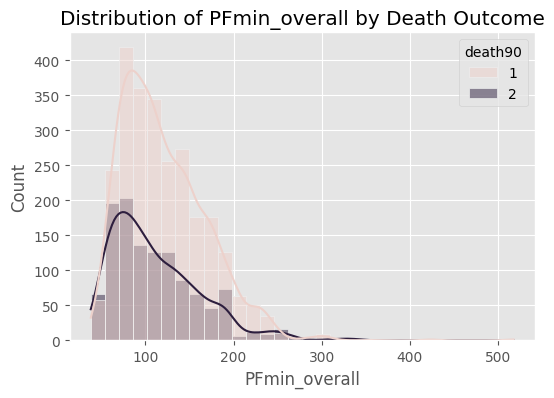

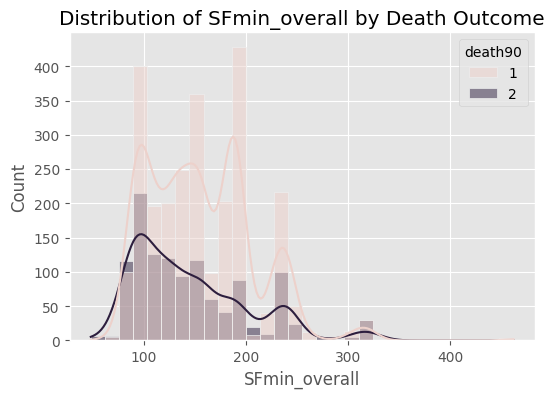

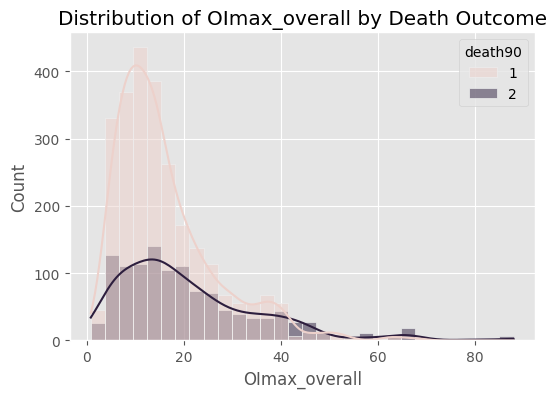

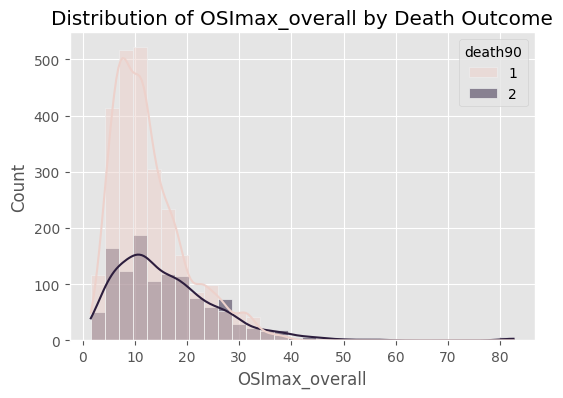

In [17]:
#visualize what features are best predictors of alive, death, and unknown
for feature in nb_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=nb_df, x=feature, hue="death90", kde=True, bins=30)
    plt.title(f"Distribution of {feature} by Death Outcome")
    plt.show()

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

   Alive (1)       0.72      0.89      0.80       530
    Dead (2)       0.45      0.20      0.28       231

    accuracy                           0.68       761
   macro avg       0.59      0.55      0.54       761
weighted avg       0.64      0.68      0.64       761



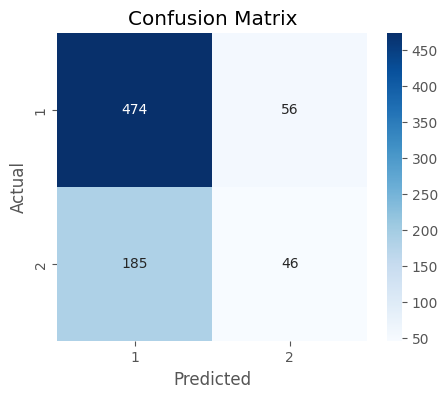

In [16]:
#implementation step of classifier

#split data into training and test sets with separation of 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(nb_df[nb_features], nb_df[target1], test_size=0.2, random_state=47)

#Initialize model
nb_model = GaussianNB()

#Train model on training data
nb_model.fit(X_train, y_train)

#Predict on test data
y_pred = nb_model.predict(X_test)

#evaluate the model for accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#print classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Alive (1)", "Dead (2)"]))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=[1,2], yticklabels=[1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
#To see which severe feature, PFmin, SFmin, OImax, OSImax is the best predictor for death at 90 days will train 4 separate
#models to see which performs best

#Dictionary to store results
feature_performance = {}

for feature in nb_features:
    print(f"Training model with feature: {feature}")
    
    #Prepare data with only one feature
    X = nb_df[[feature]]
    y = nb_df['death90']
    
    #split data into training and test sets with separation of 80% training data, 20% testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
    
    #Initialize and train model
    model = GaussianNB()
    model.fit(X_train, y_train)
    
    #Predict model
    y_pred = model.predict(X_test)
    
    #Determine model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    #store results
    feature_performance[feature] = accuracy

#Print summary of feature importance
print("\nFeature Performance Summary:")
for feature, acc in feature_performance.items():
    print(f"{feature}: {acc:.2f}")

Training model with feature: PFmin_overall
Accuracy: 0.70
Training model with feature: SFmin_overall
Accuracy: 0.70
Training model with feature: OImax_overall
Accuracy: 0.70
Training model with feature: OSImax_overall
Accuracy: 0.70

Feature Performance Summary:
PFmin_overall: 0.70
SFmin_overall: 0.70
OImax_overall: 0.70
OSImax_overall: 0.70


**Shunt Predictor**

In [19]:
#Need to define bins and labels based on clinical interpretation of shunt severity
bins = [-float('inf'), 0.10, 0.19, 0.29, float('inf')]  # Ranges for binning
labels = ['Normal', 'Mild', 'Moderate', 'Severe']  # Category names

# Apply binning
nb_df['Shuntmax_category'] = pd.cut(nb_df['Shuntmax_overall'], bins=bins, labels=labels)

# Check distribution of categories
print(nb_df['Shuntmax_category'].value_counts())

Shuntmax_category
Severe      937
Moderate    329
Mild        146
Normal       26
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

        Mild       0.90      0.85      0.88        33
    Moderate       0.62      0.82      0.71        65
      Normal       0.71      0.71      0.71         7
      Severe       0.92      0.83      0.87       183

    accuracy                           0.82       288
   macro avg       0.79      0.80      0.79       288
weighted avg       0.84      0.82      0.83       288



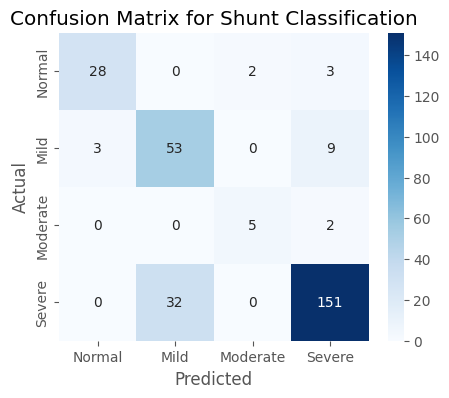

<function confusion_matrix at 0x12cd2a8e0>


In [39]:
#define features and categories based on clinical interpretation above
X = nb_df[features].dropna()
y = nb_df['Shuntmax_category'].loc[X.index] #ensures matching index

#split data into training and test sets with separation of 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

#Initialize and train model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

#Predict on test set
y_pred = nb_model.predict(X_test)

#Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Shunt Classification")
plt.show()


In [32]:
#create dictionary to store results
shunt_performance = {}

for feature in nb_features:
    print(f"Training model with feature: {feature}")

    #Drop rows where the feature or target is missing, there will be a lot of dropped rows since there is a lot of missing data in shunt
    df_clean = nb_df[[feature, 'Shuntmax_category']].dropna()

    X = df_clean[[feature]]
    y = df_clean['Shuntmax_category']

    #split data into training and test sets with separation of 80% training data, 20% testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

    #Initialize and train model
    model = GaussianNB()
    model.fit(X_train, y_train)

    #Predict model
    y_pred = model.predict(X_test)

    #Determine model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    #store results
    shunt_performance[feature] = accuracy

#print summary of feature importance
print("\nFeature Performance Summary (Predicting Shuntmax_overall):")
for feature, acc in shunt_performance.items():
    print(f"{feature}: {acc:.2f}")

Training model with feature: PFmin_overall
Accuracy: 0.66
Training model with feature: SFmin_overall
Accuracy: 0.63
Training model with feature: OImax_overall
Accuracy: 0.64
Training model with feature: OSImax_overall
Accuracy: 0.64

Feature Performance Summary (Predicting Shuntmax_overall):
PFmin_overall: 0.66
SFmin_overall: 0.63
OImax_overall: 0.64
OSImax_overall: 0.64


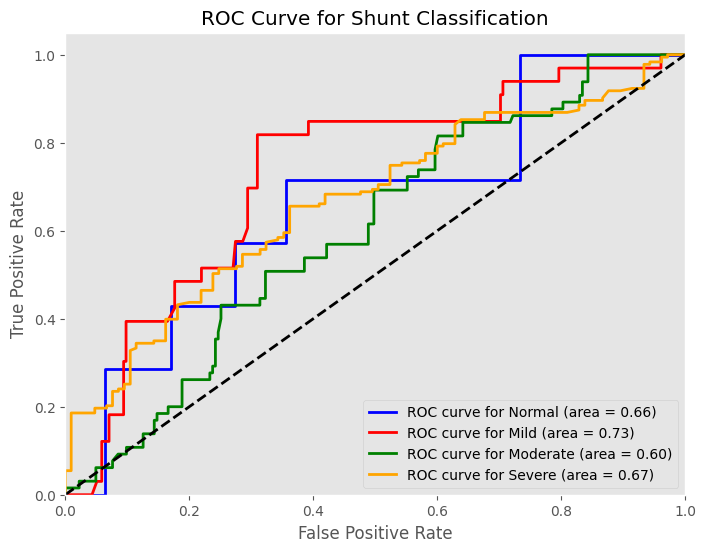

In [36]:
#binarize the output labels (for ROC curve)
y_train_bin = label_binarize(y_train, classes=labels)
y_test_bin = label_binarize(y_test, classes=labels)
n_classes = y_train_bin.shape[1]

# Train model using One-vs-Rest strategy
classifier = OneVsRestClassifier(GaussianNB())
classifier.fit(X_train, y_train_bin)
y_score = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot all ROC curves for every shunt severity
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Shunt Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()